In [1]:
path = !(echo $(pwd))

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.path.dirname(path[0])))

import numpy as np
import chess
import tensorflow
from tensorflow import keras

from src.preprocessing.board_representation import board_to_token_sequence, token_sequence_to_board
from src.evaluation.old_visualisation import *
from src.utils.data_loader import load_train_test
from src.modeling.model import PositionPredictionHead

2023-10-16 22:38:34.462000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 22:38:34.491912: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-16 22:38:34.492689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 22:38:35.199418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [3]:
print(tensorflow.__version__)

2.13.1


In [4]:
train_data, test_data = load_train_test("../../data", "position_tensor_000")
print(len(train_data), len(test_data))

90000 10000


In [5]:
autoencoder = keras.models.load_model("../../model/20231016214738_autoencoder.tf")
autoencoder_predictor = PositionPredictionHead(backend=autoencoder)

# Encoder and decoder evaluation

In [6]:
index = 3141

In [7]:
sample = test_data[index].reshape((1,69))

In [8]:
reconstruction = autoencoder_predictor.predict_on_batch(sample)

In [9]:
tensorflow.math.count_nonzero(tensorflow.subtract(sample, reconstruction), axis=-1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [10]:
autoencoder.evaluate(sample, reconstruction, return_dict=True), autoencoder_predictor.evaluate(x=sample)

1/1 [==============================] - 0s 329ms/step - loss: 1.5776e-05 - sparse_categorical_accuracy: 1.0000


({'loss': 1.5775851352373138e-05, 'sparse_categorical_accuracy': 1.0},
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [11]:
sample_board = token_sequence_to_board(sample[0])
reconstructed_board = token_sequence_to_board(reconstruction[0].numpy())

In [12]:
print_board(sample_board)

r . . . . r k .
p p . . . p p p
. . p . . . b .
b . . N P . . .
. . . . n P P q
. B . . B Q . P
P P . . . . . .
R . . . . R K .




In [13]:
print_board(reconstructed_board)

r . . . . r k .
p p . . . p p p
. . p . . . b .
b . . N P . . .
. . . . n P P q
. B . . B Q . P
P P . . . . . .
R . . . . R K .




# Position similarity search

In [14]:
encoder = autoencoder.get_layer('encoder')
decoder = autoencoder.get_layer('decoder')
decoder_predictor = PositionPredictionHead(backend=decoder)

In [15]:
chess_positions = {
    "game_1_catalan_opening" : chess.Board(fen="r1bqr1k1/pp1nnpbp/2p3p1/4p3/4P3/4BNP1/PPPQ1PBP/RN2R1K1 w - - 2 11"), # game 1 - catalan opening
    "game_1_one_move_later" : chess.Board(fen="r1bqr1k1/pp1nnpbp/2p3pB/4p3/4P3/5NP1/PPPQ1PBP/RN2R1K1 b - - 3 11"),
    "game_1_few_moves_later" : chess.Board(fen="r3r3/ppq1npkp/2p3p1/2n1p2P/4P1b1/5NP1/PPPQ1PB1/RN2R1K1 w - - 1 15"),
    "game_1_middle_game" : chess.Board(fen="7r/p3npk1/2p4r/1p2N1p1/1P2P3/2P3P1/P4PK1/3RR3 w - - 0 28"),
    "game_1_end_game" : chess.Board(fen="8/8/8/1N3k2/1n3Pp1/6P1/5K2/8 w - - 0 43"),
    "game_2_catalan_opening" : chess.Board(fen="rn1qk2r/pp2bppp/2p5/3p1b2/3PnB2/2N2NP1/PP2PPBP/R2Q1RK1 b kq - 1 9"),
    "game_2_middle_game" : chess.Board(fen="r2r2k1/pQ3ppp/3q4/3P1b2/2R5/6P1/P4PBP/5RK1 b - - 0 21")
}

In [16]:
embeddings = {}
for key, board in chess_positions.items():
    input = board_to_token_sequence(board).reshape((1,-1))
    embeddings[key] = encoder.predict(input).reshape((-1,))

1/1 [==============================] - 0s 18ms/step


In [17]:
embeddings

{'game_1_catalan_opening': array([-4.19925302e-01, -4.58452925e-02, -3.78784448e-01,  2.10172907e-01,
        -6.81471050e-01, -6.24131143e-01,  4.95396182e-02,  6.86741918e-02,
         3.29874009e-01,  1.22865848e-01,  1.69858441e-01,  7.14912415e-01,
         2.57018298e-01, -2.61275530e-01,  1.73144177e-01,  3.28127265e-01,
        -4.87047702e-01,  5.75815499e-01,  6.79563046e-01,  1.40134558e-01,
         2.36420929e-01, -5.48814595e-01,  5.47345281e-01, -3.23397905e-01,
        -7.66011141e-03,  7.22809136e-01,  5.62543929e-01,  6.82814956e-01,
         7.44699538e-01,  4.79412168e-01, -6.61945224e-01,  2.68859506e-01,
        -1.69046447e-02, -3.09765548e-01,  3.83308560e-01, -5.69566935e-02,
        -2.97145665e-01, -3.34310919e-01, -2.77217865e-01, -3.59698206e-01,
        -6.35541859e-04, -3.18920970e-01, -2.52864093e-01,  4.26751047e-01,
        -2.59811968e-01, -3.07109237e-01, -3.47829834e-02, -4.31118429e-01,
        -2.67258316e-01, -5.43339610e-01,  3.32903087e-01,  6.

In [18]:
reverse_embeddings = {v.tobytes(): k for k,v in embeddings.items()}
reverse_reverse = {v: np.frombuffer(k, dtype=np.float32) for k,v in reverse_embeddings.items()}

In [19]:
np.allclose(embeddings["game_1_catalan_opening"], reverse_reverse["game_1_catalan_opening"])

True

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

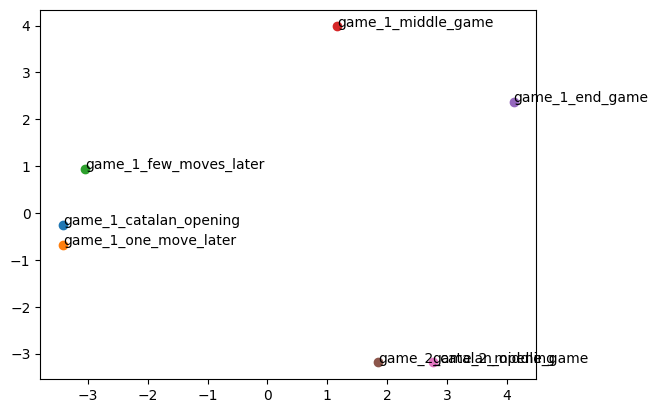

In [21]:
vectors = list(embeddings.values())
reducer = PCA(n_components=2)
#reducer = umap.UMAP()
projected = reducer.fit_transform(vectors)

# Creating a scatter plot with annotations
fig, ax = plt.subplots()
for i, (key, value) in enumerate(embeddings.items()):
    ax.scatter(projected[i, 0], projected[i, 1])
    ax.text(projected[i, 0], projected[i, 1], key)

plt.show()